In [11]:
import torch
from pytorch_transformers import *

In [2]:
MODELS = [(XLNetModel,      XLNetTokenizer,     'xlnet-base-cased')]

In [12]:
MODELS = [(BertModel,       BertTokenizer,      'bert-base-uncased')]

In [13]:
# Let's encode some text in a sequence of hidden-states using each model:
for model_class, tokenizer_class, pretrained_weights in MODELS:
    # Load pretrained model/tokenizer
    tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
    model = model_class.from_pretrained(pretrained_weights)

    # Encode text
    input_ids = torch.tensor([tokenizer.encode("Here is some text to encode", add_special_tokens=True)])  # Add special tokens takes care of adding [CLS], [SEP], <s>... tokens in the right way for each model.
    with torch.no_grad():
        last_hidden_states = model(input_ids)[0]  # Models outputs are now tuples

In [60]:
import time
start = time.time()
end = time.time()
print(end - start)

1.177896499633789


In [65]:
r1_filter

['Small restaurant but with very delicious food',
 ' The atmosphere is great',
 ' The customer service is on point',
 " I didn't try a lot of different meals so I will be back",
 " Thanks to Teddy's guide for recommending me this lovely restaurant"]

In [197]:
last_hidden_states[0]

tensor([[-0.0549,  0.1053, -0.1065,  ..., -0.3550,  0.0686,  0.6506],
        [-0.5759, -0.3650, -0.1383,  ..., -0.6782,  0.2092, -0.1639],
        [-0.1641, -0.5597,  0.0150,  ..., -0.1603, -0.1346,  0.6216],
        ...,
        [ 0.2448,  0.1254,  0.1587,  ..., -0.2749, -0.1163,  0.8809],
        [ 0.0481,  0.4950, -0.2827,  ..., -0.6097, -0.1212,  0.2527],
        [ 0.9046,  0.2137, -0.5897,  ...,  0.3040, -0.6172, -0.1950]])

In [40]:
import sklearn

In [41]:
from sklearn.metrics.pairwise import cosine_similarity

In [20]:
last_hidden_states[0].shape

torch.Size([8, 768])

In [14]:
import json
with open('Thai_Cook.json') as outfile:
    Thai = json.load(outfile)

In [62]:
Thai['1']['review']

"One of the consistent options in Hell's Kitchen. The appetizers are delicious. I've tried the chicken satay and the calamari salad. Great flavors and fresh ingredients. At first, it does seem slightly pricey for the portion, but the quality is definitely there.\n\nI tried the Pad Thai for the main, which was tasty and a good-sized portion, but it was on the sweeter side (it didn't bother me, but just comparatively to other Thai restaurants). \n\nWe also had the pumpkin sticky rice which is delicious. I still prefer mango, but this one felt less sweet and more custard-y. \n\nI've eaten in once and the place gets packed during lunch time, but the delivery is efficient as well."

In [18]:
Thai['1']['rate'][6]

'5'

In [63]:
Thai['2']['review']

"Small restaurant but with very delicious food. The atmosphere is great. The customer service is on point. I didn't try a lot of different meals so I will be back. Thanks to Teddy's guide for recommending me this lovely restaurant."

In [247]:
# test for the accuracy of the model
# looks good
with torch.no_grad():
    input_ids1 = torch.tensor([tokenizer.encode('the smoke is very good', add_special_tokens=True)])  
    input_ids2 = torch.tensor([tokenizer.encode('I tried chicken satay', add_special_tokens=True)]) 
    input_ids3 = torch.tensor([tokenizer.encode('the smoke is that bad', add_special_tokens=True)]) 
    a = model(input_ids1)[0][0]
    b = model(input_ids2)[0][0]
    c = model(input_ids3)[0][0]

In [246]:
cosine_similarity(a.reshape(1,7*768),c.reshape(1,7*768))

array([[0.7691654]], dtype=float32)

In [249]:
cosine_similarity(a.reshape(1,7*768),b.reshape(1,7*768))

array([[0.5327879]], dtype=float32)

In [7]:
# clean the data for Thai
data = {}
idx = 0
for i in range(1,len(Thai)+1):
    key = str(i)
    if len(Thai[key]['review']) > 0:
        data[idx] = Thai[key]['review']
        idx += 1

In [34]:
# pick several data from the reviews
data = {}
five = []
four = []
two = []
one = []
for i in range(1,len(Thai)+1):
    key = str(i)
    if Thai[key]['rate'][6] == '5' and len(Thai[key]['review']) > 0:
        five.append(key)
    if Thai[key]['rate'][6] == '4' and len(Thai[key]['review']) > 0:
        four.append(key)
    if Thai[key]['rate'][6] == '2' and len(Thai[key]['review']) > 0:
        two.append(key)
    if Thai[key]['rate'][6] == '1' and len(Thai[key]['review']) > 0:
        one.append(key)
pick = five[:3]+four[:3]+two[:3]+one[:3]
idx = 0
for k in pick:
    data[idx] = Thai[k]['review']
    idx+=1

In [35]:
data

{0: "One of the consistent options in Hell's Kitchen. The appetizers are delicious. I've tried the chicken satay and the calamari salad. Great flavors and fresh ingredients. At first, it does seem slightly pricey for the portion, but the quality is definitely there.\n\nI tried the Pad Thai for the main, which was tasty and a good-sized portion, but it was on the sweeter side (it didn't bother me, but just comparatively to other Thai restaurants). \n\nWe also had the pumpkin sticky rice which is delicious. I still prefer mango, but this one felt less sweet and more custard-y. \n\nI've eaten in once and the place gets packed during lunch time, but the delivery is efficient as well.",
 1: "Small restaurant but with very delicious food. The atmosphere is great. The customer service is on point. I didn't try a lot of different meals so I will be back. Thanks to Teddy's guide for recommending me this lovely restaurant.",
 2: "Amazing! One of the highlights of our NYC visit. I heard the pork 

In [77]:
data[1].split('.')

['Small restaurant but with very delicious food',
 ' The atmosphere is great',
 ' The customer service is on point',
 " I didn't try a lot of different meals so I will be back",
 " Thanks to Teddy's guide for recommending me this lovely restaurant",
 '']

In [36]:
# calculate the sentence similarity, use the short sentence as ngrams.
def sentence_similarity(a,b):
    sim = []
    with torch.no_grad():
        input_ids1 = torch.tensor([tokenizer.encode(a, add_special_tokens=True)])  
        input_ids2 = torch.tensor([tokenizer.encode(b, add_special_tokens=True)]) 
        express1 = model(input_ids1)[0][0]
        express2 = model(input_ids2)[0][0]
        if express1.shape[0] <= express2.shape[0]:
            ngram = express1.shape[0]
            sentence = express1.reshape(1,ngram*768) 
            for i in range(0,express2.shape[0]-ngram+1):
                new_sentence = express2[i:i+ngram,:].reshape(1,ngram*768)
                sim.append(cosine_similarity(sentence,new_sentence)[0][0])
        else:
            ngram = express2.shape[0]
            sentence = express2.reshape(1,ngram*768) 
            for i in range(0,express1.shape[0]-ngram+1):
                new_sentence = express1[i:i+ngram,:].reshape(1,ngram*768)
                sim.append(cosine_similarity(sentence,new_sentence)[0][0])
        
    return max(sim)

In [308]:
sentence_similarity(a,b)

0.45692375

In [37]:
# start build the similarity network
import networkx as nx
import numpy as np
G = nx.DiGraph()
for i in range(len(data)):
    G.add_node(i,review=data[i]) 

In [80]:
r1_filter = [x for x in data[1].split('.') if len(x)>1]
r2_filter = [x for x in data[2].split('.') if len(x)>1]
max([sentence_similarity(r1_filter[0],b) for b in r2_filter])

0.50880414

In [42]:
# create a direction graph will weights is the average similarity of the sentence.
import time
start = time.time()
for i in range(len(data)):
    r1 = data[i].split('.')
    r1_filter = [x for x in r1 if len(x)>1]
    n = len(r1_filter)
    for j in range(len(data)):
        weight = []
        r2 = data[j].split('.')
        r2_filter = [x for x in r2 if len(x)>1]
        if i != j:
            for k in range(n):
                weight.append(max([sentence_similarity(r1_filter[k],b) for b in r2_filter]))
            G.add_edges_from([(i,j,{'similarity':np.mean(weight)})])
    print(i)
    
end = time.time()
print(end - start)

0
1
2
3
4
5
6
7
8
9
10
11
606.8057401180267


In [43]:
G.edges.data()

OutEdgeDataView([(0, 1, {'similarity': 0.45077175}), (0, 2, {'similarity': 0.43673378}), (0, 3, {'similarity': 0.46471038}), (0, 4, {'similarity': 0.4477646}), (0, 5, {'similarity': 0.47435385}), (0, 6, {'similarity': 0.37760496}), (0, 7, {'similarity': 0.39272523}), (0, 8, {'similarity': 0.4279184}), (0, 9, {'similarity': 0.33065912}), (0, 10, {'similarity': 0.4309511}), (0, 11, {'similarity': 0.39557877}), (1, 0, {'similarity': 0.49408388}), (1, 2, {'similarity': 0.46015388}), (1, 3, {'similarity': 0.47843808}), (1, 4, {'similarity': 0.5196943}), (1, 5, {'similarity': 0.4957859}), (1, 6, {'similarity': 0.38549155}), (1, 7, {'similarity': 0.37662363}), (1, 8, {'similarity': 0.48666018}), (1, 9, {'similarity': 0.38160467}), (1, 10, {'similarity': 0.43191808}), (1, 11, {'similarity': 0.41941595}), (2, 0, {'similarity': 0.4676703}), (2, 1, {'similarity': 0.44744048}), (2, 3, {'similarity': 0.45975918}), (2, 4, {'similarity': 0.44322267}), (2, 5, {'similarity': 0.46328527}), (2, 6, {'simi

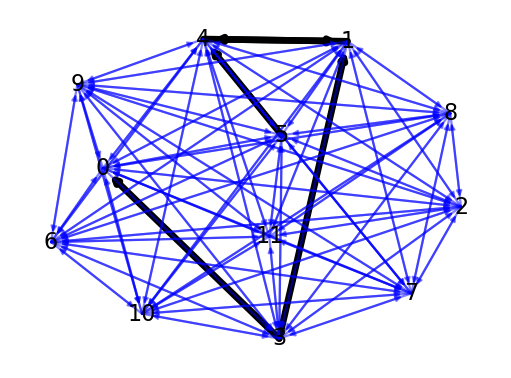

In [45]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d['similarity'] > 0.5]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d['similarity'] <= 0.5]
pos = nx.spring_layout(G) 
nx.draw_networkx_edges(G, pos, edgelist=elarge,
                       width=6)
nx.draw_networkx_edges(G, pos, edgelist=esmall,
                       width=2, alpha=0.5, edge_color='b', style='dashed')
nx.draw_networkx_labels(G, pos, font_size=20, font_family='sans-serif')

plt.axis('off')
plt.show()

In [46]:
# write to pickle
nx.write_gpickle(G,'test.gpickle')

In [2]:
import networkx as nx
import numpy as np
# read pickle
G = nx.read_gpickle('test.gpickle')